# Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf 
import lmfit # source: https://lmfit.github.io/lmfit-py/
from lmfit import minimize, Parameters, fit_report
from tqdm import tqdm
import multiprocessing
from astropy.timeseries import LombScargle
import os
import time
np.random.seed(110)

# Creation du template pour une raie

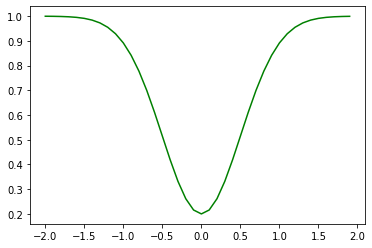

In [6]:
def Gauss(x, a, sigma):
        return 1 - a * np.exp(-x**2 / (2 * sigma**2))


def skewed_gaussian(x, a, sigma, alpha) :
    def cdf(x) :
        return((1/2)*(1+erf(x/np.sqrt(2))))

    return 1 + (2/sigma)*(-a/2)*np.exp(-(x)**2 / (2 * sigma**2))*cdf(alpha*(x)/sigma)


a0 = 0.8
sigma_0 = 0.5

x = np.arange(-2,2,1/10) 
Template = Gauss(x, a0, sigma_0)

plt.plot(x, Template, "g")
plt.show()

# Création d'une raie

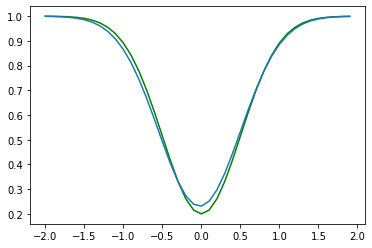

In [7]:
a = a0 + np.random.randn()/50
sigma = sigma_0 + np.random.randn()/50
xoff = np.random.randn()/50

line = Gauss(x+xoff, a, sigma)

plt.plot(x, Template, "g")
plt.plot(x, line)
plt.show()

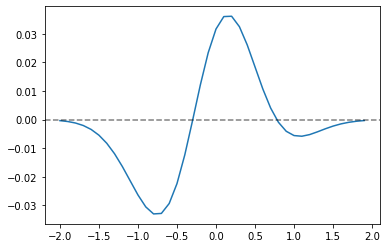

In [8]:
# Plot difference
plt.plot(x, line - Template)
plt.axhline(0,c='k', linestyle='--', alpha=0.5)
plt.show()

According the Bouchy's framework (Bouchy et al. 2001; Artigau et al. 2022):

$A(i)-A_0(i) = d_{temp} + dv \frac{d A_0(i)}{d \lambda(i)} + d_{LW} \frac{d^2 A_0(i)}{d \lambda(i)^2} + d³v \frac{d^3 A_0(i)}{d \lambda(i)^3} + \mathcal{O}(\frac{d^3 A_0(i)}{d \lambda(i)^3}) $

# lets then fit the bouchy equation to find $d_{temp}$, $dv$, $d_{LW}$ and $d³v$

In [9]:
d1 = np.gradient(Template, x)
d2 = np.gradient(d1, x)
d3 = np.gradient(d2, x)
diff_seg = line-Template

def equation(params, d1, d2, d3, diff):
    d0v = params.get('d0v').value
    dv  = params.get('dv').value
    d2v = params.get('d2v').value
    d3v = params.get('d3v').value
    zero = d0v + dv*d1 + d2v*d2 + d3v*d3 - diff
    return(zero)

#initialize
params_ini = Parameters()
params_ini.add('d0v', value=0, min=-np.inf, max=np.inf)
params_ini.add('dv', value=0, min=-np.inf, max=np.inf)
params_ini.add('d2v', value=0, min=-np.inf, max=np.inf)
params_ini.add('d3v', value=0, min=-np.inf, max=np.inf)
#fit
out = minimize(equation, params_ini, args = (d1, d2, d3, diff_seg))

#result
d0v = out.params['d0v'].value
dv = out.params['dv'].value
d2v = out.params['d2v'].value
d3v = out.params['d3v'].value

sd0v = out.params['d0v'].stderr
sdv = out.params['dv'].stderr
sd2v = out.params['d2v'].stderr
sd3v = out.params['d3v'].stderr

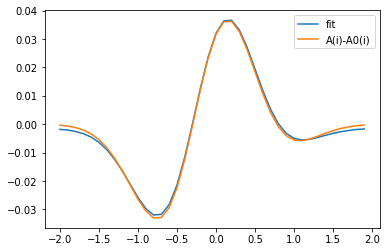

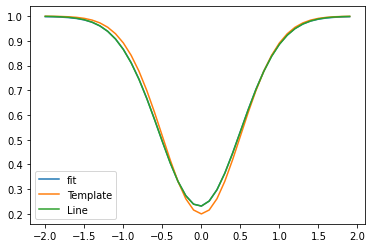

In [10]:
plt.plot(x, equation(out.params, d1, d2, d3, diff_seg)+diff_seg, label='fit')
plt.plot(x, diff_seg, label='A(i)-A0(i)')
plt.legend()
plt.show()

plt.plot(x, equation(out.params, d1, d2, d3, diff_seg)+diff_seg+Template, label='fit')
plt.plot(x, Template, label='Template')
plt.plot(x, line, label='Line')
plt.legend()
plt.show()

In [11]:
print('d0v = ', d0v, ' +/- ', sd0v)
print('dv  = ', dv, ' +/- ', sdv)
print('d2v = ', d2v, ' +/- ', sd2v)
print('d3v = ', d3v, ' +/- ', sd3v)

d0v =  -0.0015480841253856885  +/-  0.00014901632343421983
dv  =  0.023067634818033842  +/-  0.0004558306659493223
d2v =  0.010890259781035527  +/-  0.00011807824402013735
d3v =  0.00023020148185559048  +/-  6.242332806458226e-05


# Modulates Contrast/line depth

In [12]:
times = np.linspace(0, 2*np.pi, 20) 
a_serie = 0.05 * np.sin(times)

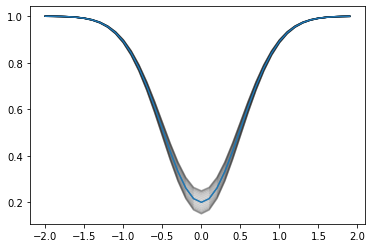

In [13]:
d0v, dv, d2v, d3v     = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
sd0v, sdv, sd2v, sd3v = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))

for i in range(len(times)):
    #generate line 
    line = Gauss(x, a0+a_serie[i], sigma_0)
    plt.plot(x, line, 'k', alpha=0.2)
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, line-Template))
    
    d0v[i] = out.params['d0v'].value
    dv[i]  = out.params['dv'].value
    d2v[i] = out.params['d2v'].value
    d3v[i] = out.params['d3v'].value

    sd0v[i] = out.params['d0v'].stderr
    sdv[i]  = out.params['dv'].stderr
    sd2v[i] = out.params['d2v'].stderr
    sd3v[i] = out.params['d3v'].stderr
plt.plot(x, Template)
plt.show()

Text(0, 0.5, 'line depth')

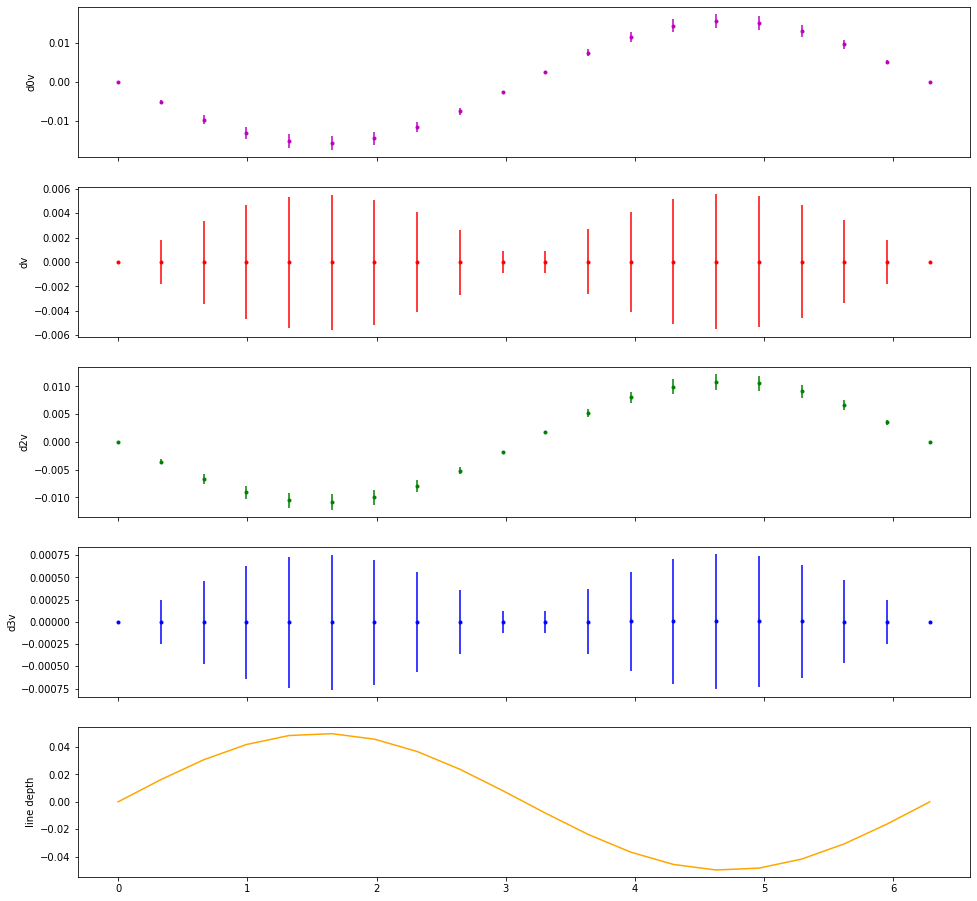

In [14]:
fig, ax = plt.subplots(5, 1, sharex='col', figsize=(16,16))

ax[0].errorbar(times, d0v, sd0v, fmt='m.')
ax[0].set_ylabel('d0v')

ax[1].errorbar(times, dv, sdv, fmt='r.')
ax[1].set_ylabel('dv')

ax[2].errorbar(times, d2v, sd2v, fmt='g.')
ax[2].set_ylabel('d2v')

ax[3].errorbar(times, d3v, sd3v, fmt='b.')
ax[3].set_ylabel('d3v')

ax[4].plot(times, a_serie, 'orange')
ax[4].set_ylabel('line depth')


# Modulates X-offset

In [20]:
xoff_serie = 0.1 * np.sin(times)

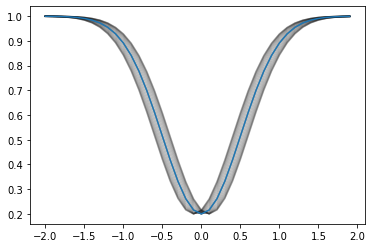

In [21]:
d0v, dv, d2v, d3v     = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
sd0v, sdv, sd2v, sd3v = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))

for i in range(len(times)):
    #generate line 
    line = Gauss(x+xoff_serie[i], a0, sigma_0)
    plt.plot(x, line, 'k', alpha=0.2)
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, line-Template))
    
    d0v[i] = out.params['d0v'].value
    dv[i]  = out.params['dv'].value
    d2v[i] = out.params['d2v'].value
    d3v[i] = out.params['d3v'].value

    sd0v[i] = out.params['d0v'].stderr
    sdv[i]  = out.params['dv'].stderr
    sd2v[i] = out.params['d2v'].stderr
    sd3v[i] = out.params['d3v'].stderr
plt.plot(x, Template)
plt.show()

Text(0, 0.5, 'x offset')

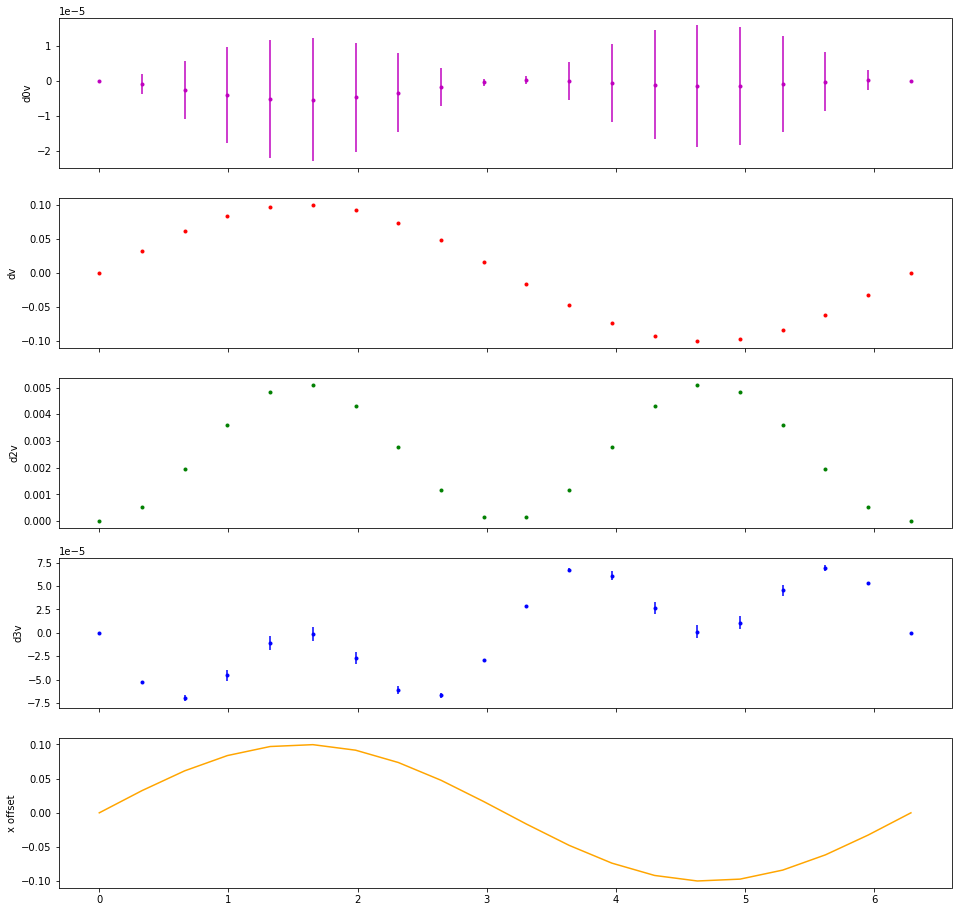

In [22]:
fig, ax = plt.subplots(5, 1, sharex='col', figsize=(16,16))

ax[0].errorbar(times, d0v, sd0v, fmt='m.')
ax[0].set_ylabel('d0v')

ax[1].errorbar(times, dv, sdv, fmt='r.')
ax[1].set_ylabel('dv')

ax[2].errorbar(times, d2v, sd2v, fmt='g.')
ax[2].set_ylabel('d2v')

ax[3].errorbar(times, d3v, sd3v, fmt='b.')
ax[3].set_ylabel('d3v')

ax[4].plot(times, xoff_serie, 'orange')
ax[4].set_ylabel('x offset')

# Modulates line width

In [29]:
sigma_serie = 0.1 * np.sin(times)

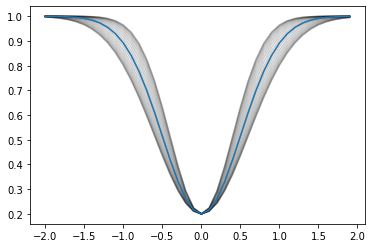

In [30]:
d0v, dv, d2v, d3v     = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
sd0v, sdv, sd2v, sd3v = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))

for i in range(len(times)):
    #generate line 
    line = Gauss(x, a0, sigma_0+sigma_serie[i])
    plt.plot(x, line, 'k', alpha=0.2)
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, line-Template))
    
    d0v[i] = out.params['d0v'].value
    dv[i]  = out.params['dv'].value
    d2v[i] = out.params['d2v'].value
    d3v[i] = out.params['d3v'].value

    sd0v[i] = out.params['d0v'].stderr
    sdv[i]  = out.params['dv'].stderr
    sd2v[i] = out.params['d2v'].stderr
    sd3v[i] = out.params['d3v'].stderr
plt.plot(x, Template)
plt.show()

Text(0, 0.5, 'sigma')

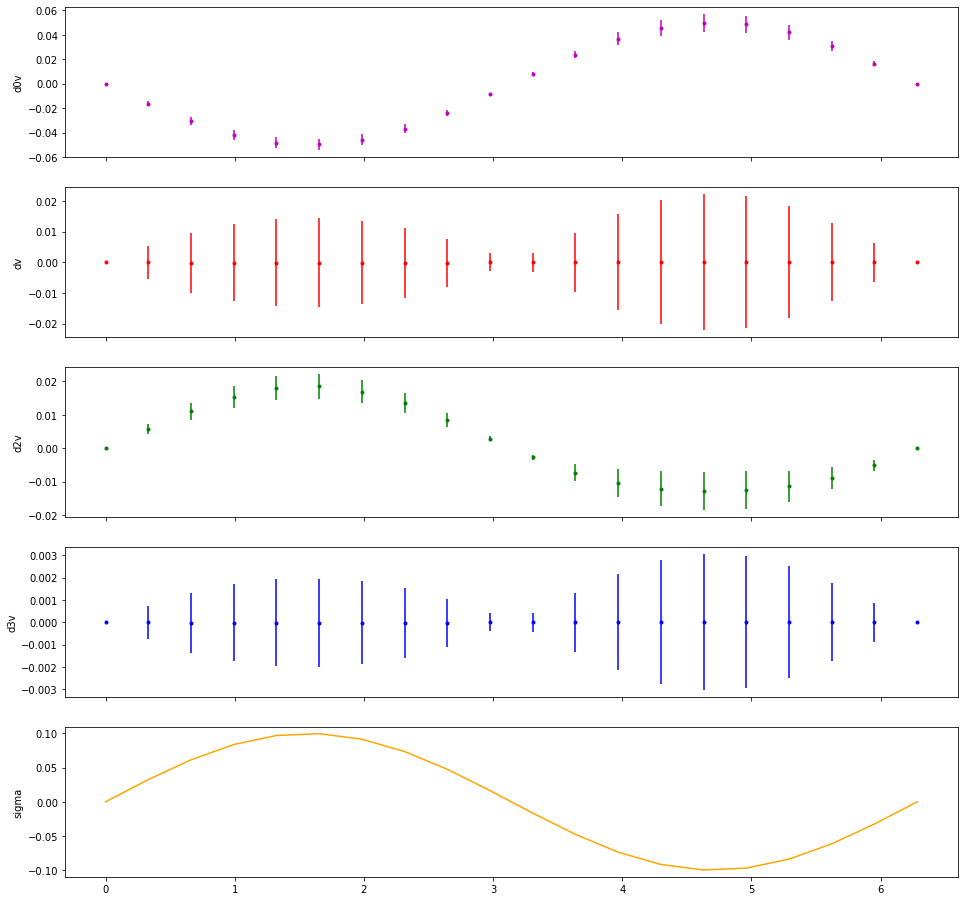

In [31]:
fig, ax = plt.subplots(5, 1, sharex='col', figsize=(16,16))

ax[0].errorbar(times, d0v, sd0v, fmt='m.')
ax[0].set_ylabel('d0v')

ax[1].errorbar(times, dv, sdv, fmt='r.')
ax[1].set_ylabel('dv')

ax[2].errorbar(times, d2v, sd2v, fmt='g.')
ax[2].set_ylabel('d2v')

ax[3].errorbar(times, d3v, sd3v, fmt='b.')
ax[3].set_ylabel('d3v')

ax[4].plot(times, sigma_serie, 'orange')
ax[4].set_ylabel('sigma')

# Assymetric lines/BIC

In [39]:
alpha_serie = 0.2 * np.sin(times)

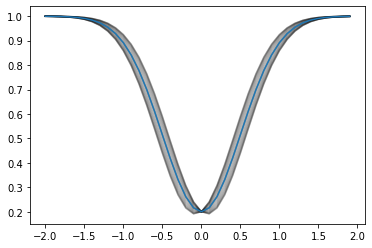

In [40]:
d0v, dv, d2v, d3v     = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
sd0v, sdv, sd2v, sd3v = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))

for i in range(len(times)):
    #generate line 
    line = skewed_gaussian(x, a0, sigma_0, alpha_serie[i])
    plt.plot(x, line, 'k', alpha=0.2)
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, line-Template))
    
    d0v[i] = out.params['d0v'].value
    dv[i]  = out.params['dv'].value
    d2v[i] = out.params['d2v'].value
    d3v[i] = out.params['d3v'].value

    sd0v[i] = out.params['d0v'].stderr
    sdv[i]  = out.params['dv'].stderr
    sd2v[i] = out.params['d2v'].stderr
    sd3v[i] = out.params['d3v'].stderr
plt.plot(x, Template)
plt.show()

Text(0, 0.5, 'alpha')

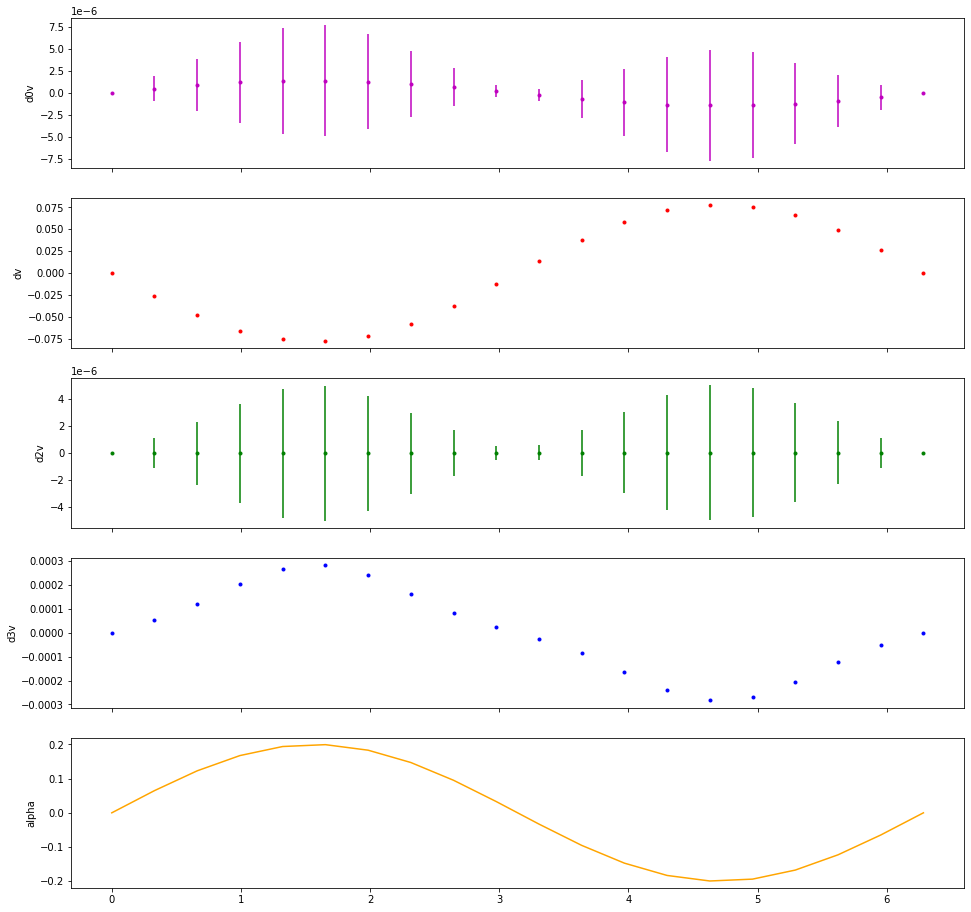

In [41]:
fig, ax = plt.subplots(5, 1, sharex='col', figsize=(16,16))

ax[0].errorbar(times, d0v, sd0v, fmt='m.')
ax[0].set_ylabel('d0v')

ax[1].errorbar(times, dv, sdv, fmt='r.')
ax[1].set_ylabel('dv')

ax[2].errorbar(times, d2v, sd2v, fmt='g.')
ax[2].set_ylabel('d2v')

ax[3].errorbar(times, d3v, sd3v, fmt='b.')
ax[3].set_ylabel('d3v')

ax[4].plot(times, alpha_serie, 'orange')
ax[4].set_ylabel('alpha')

# add photon noise   

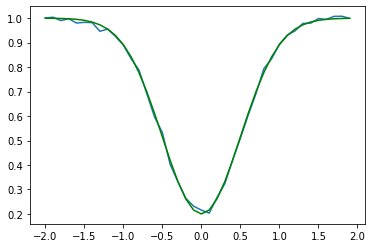

In [42]:
SNR = 100

e = np.random.randn(len(x))/SNR
plt.plot(x, Template+e)
plt.plot(x, Template, 'g')
plt.show()

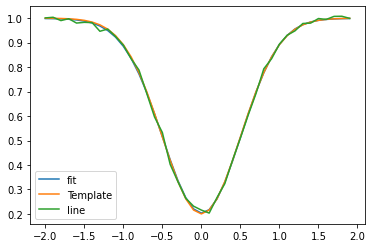

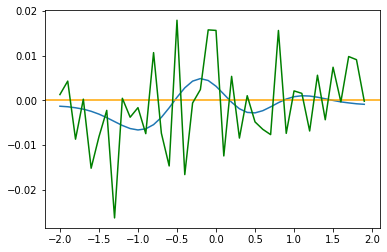

d0v =  -0.0011247709021331613  +/-  0.0015100507434034334
dv  =  0.005423201236934565  +/-  0.00461914117937264
d2v =  0.0013961736500927736  +/-  0.0011965409966694536
d3v =  0.0009482351442710094  +/-  0.0006325642102666506


In [43]:
#fit
out = minimize(equation, params_ini, args = (d1, d2, d3, e))
plt.plot(x, equation(out.params, d1, d2, d3, e)+Template+e, label='fit')
plt.plot(x, Template, label='Template')
plt.plot(x, Template+e, label='line')
plt.legend()
plt.show()

plt.plot(x, equation(out.params, d1, d2, d3, e)+e)
plt.axhline(0, c='orange')
plt.plot(x, e, 'g')
plt.plot()
plt.show()

#result
d0v = out.params['d0v'].value
dv = out.params['dv'].value
d2v = out.params['d2v'].value
d3v = out.params['d3v'].value

sd0v = out.params['d0v'].stderr
sdv = out.params['dv'].stderr
sd2v = out.params['d2v'].stderr
sd3v = out.params['d3v'].stderr

print('d0v = ', d0v, ' +/- ', sd0v)
print('dv  = ', dv, ' +/- ', sdv)
print('d2v = ', d2v, ' +/- ', sd2v)
print('d3v = ', d3v, ' +/- ', sd3v)

## Multiple lines
with Red-noise (more noisy in the bluest lines)

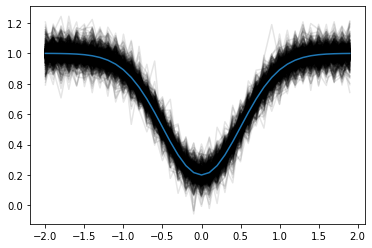

In [44]:
n_lines = 1000

d0v, dv, d2v, d3v     = np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines)
sd0v, sdv, sd2v, sd3v = np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines)

for i in range(n_lines):
    #generate line 
    e = np.random.randn(len(x))/SNR
    line = Template + e * (1 + (n_lines-i)/500)**2
    plt.plot(x, line, 'k', alpha=0.1)
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, line-Template))
    
    d0v[i] = out.params['d0v'].value
    dv[i]  = out.params['dv'].value
    d2v[i] = out.params['d2v'].value
    d3v[i] = out.params['d3v'].value

    sd0v[i] = out.params['d0v'].stderr
    sdv[i]  = out.params['dv'].stderr
    sd2v[i] = out.params['d2v'].stderr
    sd3v[i] = out.params['d3v'].stderr
plt.plot(x, Template)
plt.show()

In [45]:
def odd_ratio_mean(value, err, odd_ratio = 1e-4, nmax = 10):
    #
    # Provide values and corresponding errors and compute a
    # weighted mean
    #
    #
    # odd_bad -> probability that the point is bad
    #
    # nmax -> number of iterations
    keep = np.isfinite(value)*np.isfinite(err)
    if np.sum(keep) == 0:
        return np.nan,np.nan

    value = value[keep]
    err = err[keep]
    guess = np.nanmedian(value)
    nite = 0
    while (nite < nmax):
        nsig = (value-guess)/err
        gg = np.exp(-0.5*nsig**2)
        odd_bad = odd_ratio/(gg+odd_ratio)
        odd_good = 1-odd_bad
        w = odd_good/err**2
        guess = np.nansum(value*w)/np.nansum(w)
        nite+=1

    bulk_error = np.sqrt(1/np.nansum(odd_good/err**2))
    return guess,bulk_error


d0v_odd, sd0v_odd = odd_ratio_mean(d0v, sd0v)
dv_odd, sdv_odd   = odd_ratio_mean(dv, sdv)
d2v_odd, sd2v_odd = odd_ratio_mean(d2v, sd2v)
d3v_odd, sd3v_odd = odd_ratio_mean(d3v, sd3v)

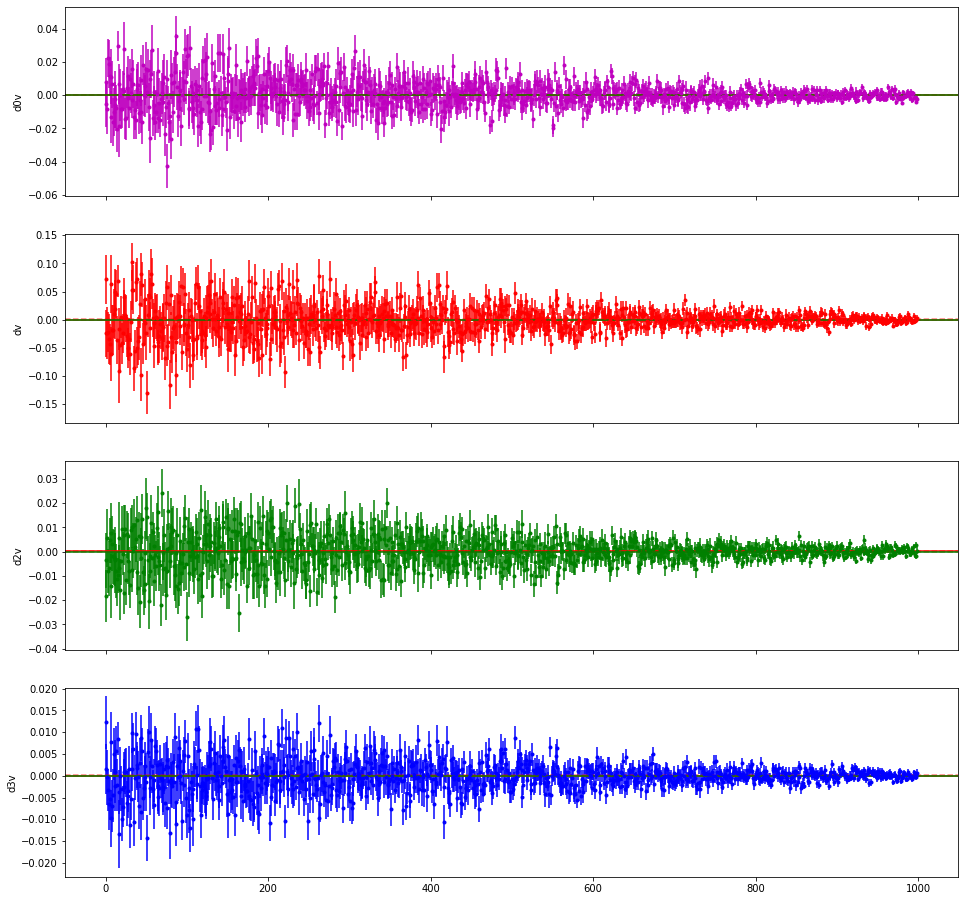

In [46]:
fig, ax = plt.subplots(4, 1, sharex='col', figsize=(16,16))

ax[0].errorbar(np.arange(n_lines), d0v, sd0v, fmt='m.')
ax[0].set_ylabel('d0v')
ax[0].axhline(d0v_odd, c='r')
ax[0].axhline(d0v_odd-sd0v_odd, c='r', linestyle='--', alpha=0.5)
ax[0].axhline(d0v_odd+sd0v_odd, c='r', linestyle='--', alpha=0.5)
ax[0].axhline(0, c='g')

ax[1].errorbar(np.arange(n_lines), dv, sdv, fmt='r.')
ax[1].set_ylabel('dv')
ax[1].axhline(dv_odd, c='r')
ax[1].axhline(dv_odd-sdv_odd, c='r', linestyle='--', alpha=0.5)
ax[1].axhline(dv_odd+sdv_odd, c='r', linestyle='--', alpha=0.5)
ax[1].axhline(0, c='g')

ax[2].errorbar(np.arange(n_lines), d2v, sd2v, fmt='g.')
ax[2].set_ylabel('d2v')
ax[2].axhline(d2v_odd, c='r')
ax[2].axhline(d2v_odd-sd2v_odd, c='r', linestyle='--', alpha=0.5)
ax[2].axhline(d2v_odd+sd2v_odd, c='r', linestyle='--', alpha=0.5)
ax[2].axhline(0, c='g')

ax[3].errorbar(np.arange(n_lines), d3v, sd3v, fmt='b.')
ax[3].set_ylabel('d3v')
ax[3].axhline(d3v_odd, c='r')
ax[3].axhline(d3v_odd-sd3v_odd, c='r', linestyle='--', alpha=0.5)
ax[3].axhline(d3v_odd+sd3v_odd, c='r', linestyle='--', alpha=0.5)
ax[3].axhline(0, c='g')

plt.show()

# build an lbl block 

for this simulated observation lets inject an RV signal at 42d and an activity signal (zeeman brodening) at 110d.
We sample it for 500 consecutive days. 
The line grid and SNR is the same as above.
## The template
1000 random gaussian lines

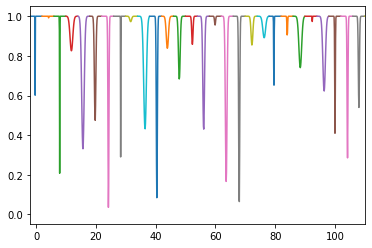

In [54]:
x = np.arange(-2,2,1/10) 

Template_Spectrum = np.zeros((n_lines, len(x)))
a_temp, sigma_temp, x_temp = np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines)

sensitivity = np.random.rand(n_lines)*2

for i in range(n_lines):
    a_l = np.random.rand()
    sigma_l = np.random.rand()/2
    x_l = np.random.rand() - 0.5
    a_temp[i], sigma_temp[i], x_temp[i] = a_l, sigma_l, x_l
    Template_l = Gauss(x-x_l, a_l, sigma_l)
    Template_Spectrum[i, :] = Template_l
    plt.plot(x+4*i, Template_l)
plt.xlim(-2, 110)
plt.show()



## Build and fit the lines

each lines are shifted from a defined RV along each realisation and broadened by a defined amountrelatively to theyre initial width (and a random sensitivity) and we add a red noise

In [55]:
## I've parallelized the process for time savings 

times = np.arange(500)
RV = 0.02 * np.sin(times*2*np.pi/42)
dLW = 0.1 * np.sin(times*2*np.pi/110)

# Define a function to process a single iteration of the inner loop
def process_iteration(t):
    np.random.seed((os.getpid() * int(time.time()))% 123456789)
    d0v, dv, d2v, d3v     = np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines)
    sd0v, sdv, sd2v, sd3v = np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines), np.zeros(n_lines)
    
    for i in range(n_lines):
        # Generate line
        e = np.random.randn(len(x)) / SNR
        line = Gauss(x+RV[t]-x_temp[i], a_temp[i], sensitivity[i]*sigma_temp[i]*(1 + dLW[t])) #  We modalutate the broadening by the actual line width
        line = line + e * (1 + (n_lines - i) / 500)**2
        
        d1_l = np.gradient(Template_Spectrum[i], x)
        d2_l = np.gradient(d1_l, x)
        d3_l = np.gradient(d2_l, x)

        # Fit
        out = minimize(equation, params_ini, args=(d1_l, d2_l, d3_l, line - Template))

        d0v[i] = out.params['d0v'].value
        dv[i]  = out.params['dv'].value
        d2v[i] = out.params['d2v'].value
        d3v[i] = out.params['d3v'].value

        sd0v[i] = out.params['d0v'].stderr
        sdv[i]  = out.params['dv'].stderr
        sd2v[i] = out.params['d2v'].stderr
        sd3v[i] = out.params['d3v'].stderr
        
    return([d0v, dv, d2v, d3v, sd0v, sdv, sd2v, sd3v])


#run
with multiprocessing.Pool() as pool:
    results = pool.map(process_iteration, times)

    
d0v   = np.array(results)[:, 0, :]
dv    = np.array(results)[:, 1, :]
d2v   = np.array(results)[:, 2, :]
d3v   = np.array(results)[:, 3, :]
sd0v  = np.array(results)[:, 4, :]
sdv   = np.array(results)[:, 5, :]
sd2v  = np.array(results)[:, 6, :]
sd3v  = np.array(results)[:, 7, :]


In [56]:
d0v_odd, dv_odd, d2v_odd, d3v_odd     = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
sd0v_odd, sdv_odd, sd2v_odd, sd3v_odd = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))

for t in times:
    d0v_odd[t], sd0v_odd[t] = odd_ratio_mean(d0v[t, :], sd0v[t, :])
    dv_odd[t], sdv_odd[t]   = odd_ratio_mean(dv[t, :], sdv[t, :])
    d2v_odd[t], sd2v_odd[t] = odd_ratio_mean(d2v[t, :], sd2v[t, :])
    d3v_odd[t], sd3v_odd[t] = odd_ratio_mean(d3v[t, :], sd3v[t, :])


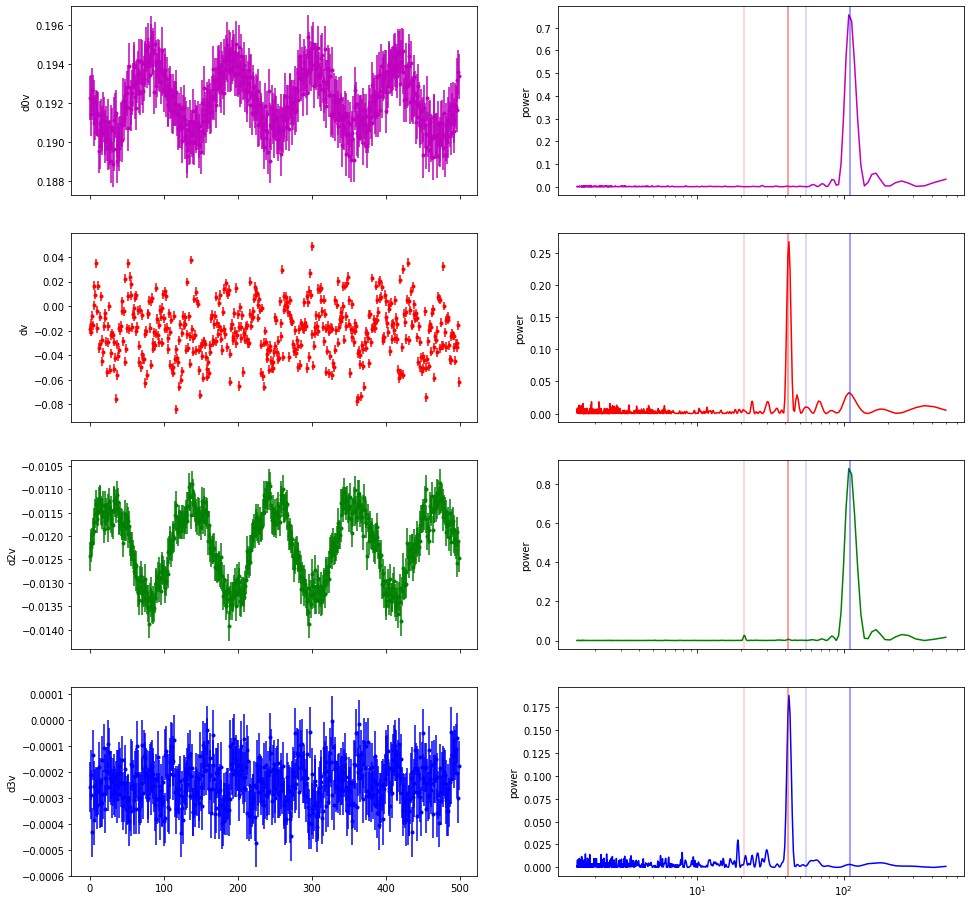

In [57]:
fig, ax = plt.subplots(4, 2, sharex='col', figsize=(16,16))
ax[0,0].errorbar(times, d0v_odd, sd0v_odd, fmt='m.')
ax[0,0].set_ylabel('d0v')

ax[1,0].errorbar(times, dv_odd, sdv_odd, fmt='r.')
ax[1,0].set_ylabel('dv')

ax[2,0].errorbar(times, d2v_odd, sd2v_odd, fmt='g.')
ax[2,0].set_ylabel('d2v')

ax[3,0].errorbar(times, d3v_odd, sd3v_odd, fmt='b.')
ax[3,0].set_ylabel('d3v')

frequency, power = LombScargle(times, d0v_odd, sd0v_odd).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[0,1].plot(1/frequency, power, 'm')
ax[0,1].set_ylabel("power")
ax[0,1].set_xscale('log')
ax[0,1].axvline(110, color='b', alpha=0.5)
ax[0,1].axvline(42, color='r', alpha=0.5)
ax[0,1].axvline(110/2, color='b', alpha=0.2)
ax[0,1].axvline(42/2, color='r', alpha=0.2)

frequency, power = LombScargle(times, dv_odd, sdv_odd).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[1,1].plot(1/frequency, power, 'r')
ax[1,1].set_ylabel("power")
ax[1,1].set_xscale('log')
ax[1,1].axvline(110, color='b', alpha=0.5)
ax[1,1].axvline(42, color='r', alpha=0.5)
ax[1,1].axvline(110/2, color='b', alpha=0.2)
ax[1,1].axvline(42/2, color='r', alpha=0.2)

frequency, power = LombScargle(times, d2v_odd, sd2v_odd).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[2,1].plot(1/frequency, power, 'g')
ax[2,1].set_ylabel("power")
ax[2,1].set_xscale('log')
ax[2,1].axvline(110, color='b', alpha=0.5)
ax[2,1].axvline(42, color='r', alpha=0.5)
ax[2,1].axvline(110/2, color='b', alpha=0.2)
ax[2,1].axvline(42/2, color='r', alpha=0.2)

frequency, power = LombScargle(times, d3v_odd, sd3v_odd).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[3,1].plot(1/frequency, power, 'b')
ax[3,1].set_ylabel("power")
ax[3,1].set_xscale('log')
ax[3,1].axvline(110, color='b', alpha=0.5)
ax[3,1].axvline(42, color='r', alpha=0.5)
ax[3,1].axvline(110/2, color='b', alpha=0.2)
ax[3,1].axvline(42/2, color='r', alpha=0.2)

plt.show()